In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import mne

# Statistical tests
from scipy import stats
from scipy.stats import shapiro, friedmanchisquare, wilcoxon, kruskal, mannwhitneyu
from scipy.stats import f_oneway, ttest_ind  # for parametric between-subjects
import itertools

# Configure plotting
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")

print("="*100)
print("COMPREHENSIVE STATISTICAL ANALYSIS - ERP AMPLITUDES")
print("="*100)
print("\n✓ Libraries loaded successfully")

COMPREHENSIVE STATISTICAL ANALYSIS - ERP AMPLITUDES

✓ Libraries loaded successfully


## 1. Load ERP Data from Preprocessed Files

In [2]:
# Load individual session ERPs
preprocessed_dir = Path('./preprocessed')

# Data structure: list of dicts
data_records = []

conditions = ['high', 'medium', 'low']
condition_labels = {'high': 'High', 'medium': 'Medium', 'low': 'Low'}

print("\nLoading ERP data from preprocessed files...\n")

for condition in conditions:
    files = sorted(preprocessed_dir.glob(f'session_*-evoked-{condition}-ave.fif'))
    print(f"{condition_labels[condition]:8s} alignment: {len(files)} sessions")
    
    for sess_file in files:
        # Parse session ID
        filename = sess_file.name
        sess_id_str = filename.split('-')[0].replace('session_', '')
        
        try:
            sess_id = int(sess_id_str)
            evoked = mne.read_evokeds(str(sess_file), verbose=False)[0]
            
            # Extract Pz channel amplitude
            ch_idx = evoked.ch_names.index('Pz')
            amplitude = np.mean(np.abs(evoked.data[ch_idx, :])) * 1e6  # µV
            
            # Store record
            data_records.append({
                'participant': sess_id,
                'condition': condition_labels[condition],
                'amplitude': amplitude
            })
        except Exception as e:
            print(f"  ⚠️ Error loading session {sess_id}: {str(e)[:50]}")

# Create DataFrame
df = pd.DataFrame(data_records)

print(f"\n✓ Loaded {len(df)} total observations")
print(f"\nData shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(10))

# Summary by condition
print(f"\n{'='*100}")
print("SAMPLE SIZES PER CONDITION")
print(f"{'='*100}")
print(df.groupby('condition').size())


Loading ERP data from preprocessed files...

High     alignment: 17 sessions
Medium   alignment: 16 sessions
Medium   alignment: 16 sessions
Low      alignment: 15 sessions
Low      alignment: 15 sessions

✓ Loaded 48 total observations

Data shape: (48, 3)

First few rows:
   participant condition     amplitude
0            0      High  2.187487e+00
1            2      High  2.918872e+00
2            5      High  1.522538e+00
3            6      High  4.835363e+00
4            7      High  1.656613e+00
5            8      High  9.439418e-01
6            9      High  2.432449e+00
7           10      High  1.223906e-10
8           11      High  1.004825e-10
9           12      High  7.806822e-01

SAMPLE SIZES PER CONDITION
condition
High      17
Low       15
Medium    16
dtype: int64

✓ Loaded 48 total observations

Data shape: (48, 3)

First few rows:
   participant condition     amplitude
0            0      High  2.187487e+00
1            2      High  2.918872e+00
2            5    

## 2. Automated Statistical Analysis Pipeline

For each dependent variable (here: ERP amplitude):
1. Test normality (Shapiro-Wilk)
2. Choose parametric vs non-parametric test
3. Run main test (One-way ANOVA or Kruskal-Wallis)
4. Post-hoc pairwise comparisons
5. Calculate effect sizes
6. Report descriptive statistics

In [3]:
# Dependent variable to analyze
dv = 'amplitude'

print("="*100)
print(f"ANALYSIS FOR: {dv.upper()} (Pz Channel, µV)")
print("="*100)

# Conditions
conditions_list = ['High', 'Medium', 'Low']

# ==============================
# 2.1 Shapiro-Wilk Test for Normality
# ==============================
print("\n" + "="*100)
print("STEP 1: NORMALITY TESTING (Shapiro-Wilk)")
print("="*100)

normal = True
normality_results = []

for cond in conditions_list:
    vals = df[df['condition'] == cond][dv].values
    
    if len(vals) >= 3:
        stat, p = shapiro(vals)
        is_normal = p > 0.05
        
        normality_results.append({
            'Condition': cond,
            'W': stat,
            'p-value': p,
            'Normal': 'Yes' if is_normal else 'No'
        })
        
        result_str = "✓ NORMAL" if is_normal else "✗ NOT NORMAL"
        print(f"{cond:8s} (n={len(vals):2d}): W={stat:.4f}, p={p:.4f} → {result_str}")
        
        if not is_normal:
            normal = False
    else:
        print(f"{cond:8s} (n={len(vals):2d}): ⚠️ Insufficient data for Shapiro-Wilk test")
        normal = False

df_normality = pd.DataFrame(normality_results)

print(f"\n{'='*100}")
if normal:
    print("✓ ALL CONDITIONS NORMAL → Use PARAMETRIC tests (One-way ANOVA)")
else:
    print("✗ AT LEAST ONE CONDITION NON-NORMAL → Use NON-PARAMETRIC tests (Kruskal-Wallis)")
print(f"{'='*100}")

ANALYSIS FOR: AMPLITUDE (Pz Channel, µV)

STEP 1: NORMALITY TESTING (Shapiro-Wilk)
High     (n=17): W=0.8302, p=0.0054 → ✗ NOT NORMAL
Medium   (n=16): W=0.6846, p=0.0001 → ✗ NOT NORMAL
Low      (n=15): W=0.6341, p=0.0001 → ✗ NOT NORMAL

✗ AT LEAST ONE CONDITION NON-NORMAL → Use NON-PARAMETRIC tests (Kruskal-Wallis)


## 3. Main Statistical Test

In [4]:
# Prepare data for tests
high_vals = df[df['condition'] == 'High'][dv].values
medium_vals = df[df['condition'] == 'Medium'][dv].values
low_vals = df[df['condition'] == 'Low'][dv].values

print("\n" + "="*100)
print("STEP 2: MAIN STATISTICAL TEST")
print("="*100)

# ==============================
# 3.1 Choose Test Based on Normality
# ==============================
if normal:
    print("\n→ Running ONE-WAY ANOVA (Parametric)\n")
    
    # One-way ANOVA for independent samples
    f_stat, p_val = f_oneway(high_vals, medium_vals, low_vals)
    
    print(f"One-Way ANOVA Results:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value: {p_val:.6f}")
    
    if p_val < 0.05:
        print(f"  ✓ SIGNIFICANT: Conditions differ significantly (p < 0.05)")
    else:
        print(f"  ✗ NOT SIGNIFICANT: No significant difference (p ≥ 0.05)")
    
    # Calculate eta-squared (effect size)
    grand_mean = np.mean(np.concatenate([high_vals, medium_vals, low_vals]))
    ss_between = len(high_vals)*(np.mean(high_vals)-grand_mean)**2 + \
                 len(medium_vals)*(np.mean(medium_vals)-grand_mean)**2 + \
                 len(low_vals)*(np.mean(low_vals)-grand_mean)**2
    ss_total = np.sum((np.concatenate([high_vals, medium_vals, low_vals]) - grand_mean)**2)
    eta_squared = ss_between / ss_total
    print(f"  η² (eta-squared): {eta_squared:.4f}")
    
else:
    print("\n→ Running KRUSKAL-WALLIS TEST (Non-parametric)\n")
    
    # Kruskal-Wallis test for independent samples
    h_stat, p_val = kruskal(high_vals, medium_vals, low_vals)
    
    print(f"Kruskal-Wallis Test Results:")
    print(f"  H-statistic: {h_stat:.4f}")
    print(f"  p-value: {p_val:.6f}")
    
    if p_val < 0.05:
        print(f"  ✓ SIGNIFICANT: Conditions differ significantly (p < 0.05)")
    else:
        print(f"  ✗ NOT SIGNIFICANT: No significant difference (p ≥ 0.05)")
    
    # Calculate epsilon-squared (effect size for Kruskal-Wallis)
    n_total = len(high_vals) + len(medium_vals) + len(low_vals)
    epsilon_squared = (h_stat - 2) / (n_total - 3)
    print(f"  ε² (epsilon-squared): {epsilon_squared:.4f}")


STEP 2: MAIN STATISTICAL TEST

→ Running KRUSKAL-WALLIS TEST (Non-parametric)

Kruskal-Wallis Test Results:
  H-statistic: 0.5378
  p-value: 0.764230
  ✗ NOT SIGNIFICANT: No significant difference (p ≥ 0.05)
  ε² (epsilon-squared): -0.0325


## 4. Post-Hoc Pairwise Comparisons

Only performed if main test is significant (p < 0.05)

In [5]:
print("\n" + "="*100)
print("STEP 3: POST-HOC PAIRWISE COMPARISONS")
print("="*100)

# Bonferroni correction
alpha_bonferroni = 0.05 / 3
print(f"\nBonferroni correction: α = 0.05 / 3 = {alpha_bonferroni:.4f}\n")

posthoc_results = []

if p_val < 0.05:  # Only if main test is significant
    print("Main test is SIGNIFICANT → Running post-hoc tests\n")
    
    if normal:
        print("→ Using INDEPENDENT T-TESTS (parametric)\n")
        
        # High vs Medium
        t_stat, p_hm = ttest_ind(high_vals, medium_vals)
        cohens_d_hm = (np.mean(high_vals) - np.mean(medium_vals)) / \
                      np.sqrt((np.var(high_vals, ddof=1) + np.var(medium_vals, ddof=1)) / 2)
        sig_hm = "✓ SIGNIFICANT" if p_hm < alpha_bonferroni else "✗ Not significant"
        print(f"High vs Medium:")
        print(f"  t={t_stat:.4f}, p={p_hm:.6f}, d={cohens_d_hm:.4f} → {sig_hm}")
        posthoc_results.append({'Comparison': 'High vs Medium', 'Statistic': t_stat, 
                               'p-value': p_hm, 'Effect_Size': cohens_d_hm, 
                               'Significant': p_hm < alpha_bonferroni})
        
        # High vs Low
        t_stat, p_hl = ttest_ind(high_vals, low_vals)
        cohens_d_hl = (np.mean(high_vals) - np.mean(low_vals)) / \
                      np.sqrt((np.var(high_vals, ddof=1) + np.var(low_vals, ddof=1)) / 2)
        sig_hl = "✓ SIGNIFICANT" if p_hl < alpha_bonferroni else "✗ Not significant"
        print(f"\nHigh vs Low:")
        print(f"  t={t_stat:.4f}, p={p_hl:.6f}, d={cohens_d_hl:.4f} → {sig_hl}")
        posthoc_results.append({'Comparison': 'High vs Low', 'Statistic': t_stat, 
                               'p-value': p_hl, 'Effect_Size': cohens_d_hl, 
                               'Significant': p_hl < alpha_bonferroni})
        
        # Medium vs Low
        t_stat, p_ml = ttest_ind(medium_vals, low_vals)
        cohens_d_ml = (np.mean(medium_vals) - np.mean(low_vals)) / \
                      np.sqrt((np.var(medium_vals, ddof=1) + np.var(low_vals, ddof=1)) / 2)
        sig_ml = "✓ SIGNIFICANT" if p_ml < alpha_bonferroni else "✗ Not significant"
        print(f"\nMedium vs Low:")
        print(f"  t={t_stat:.4f}, p={p_ml:.6f}, d={cohens_d_ml:.4f} → {sig_ml}")
        posthoc_results.append({'Comparison': 'Medium vs Low', 'Statistic': t_stat, 
                               'p-value': p_ml, 'Effect_Size': cohens_d_ml, 
                               'Significant': p_ml < alpha_bonferroni})
        
    else:
        print("→ Using MANN-WHITNEY U TESTS (non-parametric)\n")
        
        # High vs Medium
        u_stat, p_hm = mannwhitneyu(high_vals, medium_vals, alternative='two-sided')
        r_hm = 1 - (2*u_stat) / (len(high_vals) * len(medium_vals))  # rank-biserial
        sig_hm = "✓ SIGNIFICANT" if p_hm < alpha_bonferroni else "✗ Not significant"
        print(f"High vs Medium:")
        print(f"  U={u_stat:.4f}, p={p_hm:.6f}, r={r_hm:.4f} → {sig_hm}")
        posthoc_results.append({'Comparison': 'High vs Medium', 'Statistic': u_stat, 
                               'p-value': p_hm, 'Effect_Size': r_hm, 
                               'Significant': p_hm < alpha_bonferroni})
        
        # High vs Low
        u_stat, p_hl = mannwhitneyu(high_vals, low_vals, alternative='two-sided')
        r_hl = 1 - (2*u_stat) / (len(high_vals) * len(low_vals))
        sig_hl = "✓ SIGNIFICANT" if p_hl < alpha_bonferroni else "✗ Not significant"
        print(f"\nHigh vs Low:")
        print(f"  U={u_stat:.4f}, p={p_hl:.6f}, r={r_hl:.4f} → {sig_hl}")
        posthoc_results.append({'Comparison': 'High vs Low', 'Statistic': u_stat, 
                               'p-value': p_hl, 'Effect_Size': r_hl, 
                               'Significant': p_hl < alpha_bonferroni})
        
        # Medium vs Low
        u_stat, p_ml = mannwhitneyu(medium_vals, low_vals, alternative='two-sided')
        r_ml = 1 - (2*u_stat) / (len(medium_vals) * len(low_vals))
        sig_ml = "✓ SIGNIFICANT" if p_ml < alpha_bonferroni else "✗ Not significant"
        print(f"\nMedium vs Low:")
        print(f"  U={u_stat:.4f}, p={p_ml:.6f}, r={r_ml:.4f} → {sig_ml}")
        posthoc_results.append({'Comparison': 'Medium vs Low', 'Statistic': u_stat, 
                               'p-value': p_ml, 'Effect_Size': r_ml, 
                               'Significant': p_ml < alpha_bonferroni})
    
    # Summary table
    df_posthoc = pd.DataFrame(posthoc_results)
    print(f"\n{'='*100}")
    print("POST-HOC SUMMARY TABLE")
    print(f"{'='*100}")
    print(df_posthoc.to_string(index=False))
    
else:
    print("Main test is NOT SIGNIFICANT → Skipping post-hoc tests")


STEP 3: POST-HOC PAIRWISE COMPARISONS

Bonferroni correction: α = 0.05 / 3 = 0.0167

Main test is NOT SIGNIFICANT → Skipping post-hoc tests


## 5. Descriptive Statistics

In [6]:
print("\n" + "="*100)
print("STEP 4: DESCRIPTIVE STATISTICS")
print("="*100 + "\n")

descriptive_stats = []

for cond in conditions_list:
    vals = df[df['condition'] == cond][dv].values
    
    if len(vals) > 0:
        descriptive_stats.append({
            'Condition': cond,
            'N': len(vals),
            'Mean': np.mean(vals),
            'SD': np.std(vals, ddof=1),
            'Median': np.median(vals),
            'Min': np.min(vals),
            'Max': np.max(vals),
            'SEM': np.std(vals, ddof=1) / np.sqrt(len(vals))
        })
        
        print(f"{cond:8s} (n={len(vals):2d}):")
        print(f"  Mean ± SD: {np.mean(vals):.2f} ± {np.std(vals, ddof=1):.2f} µV")
        print(f"  Median: {np.median(vals):.2f} µV")
        print(f"  Range: [{np.min(vals):.2f}, {np.max(vals):.2f}] µV")
        print()

df_descriptive = pd.DataFrame(descriptive_stats)

print(f"{'='*100}")
print("DESCRIPTIVE STATISTICS TABLE")
print(f"{'='*100}")
print(df_descriptive.to_string(index=False))


STEP 4: DESCRIPTIVE STATISTICS

High     (n=17):
  Mean ± SD: 1.22 ± 1.27 µV
  Median: 0.78 µV
  Range: [0.00, 4.84] µV

Medium   (n=16):
  Mean ± SD: 1.60 ± 2.31 µV
  Median: 0.65 µV
  Range: [0.00, 7.42] µV

Low      (n=15):
  Mean ± SD: 1.16 ± 1.81 µV
  Median: 0.49 µV
  Range: [0.00, 7.08] µV

DESCRIPTIVE STATISTICS TABLE
Condition  N     Mean       SD   Median          Min      Max      SEM
     High 17 1.219689 1.272337 0.780682 1.004825e-10 4.835363 0.308587
   Medium 16 1.595818 2.309946 0.654317 8.031881e-11 7.422710 0.577487
      Low 15 1.163149 1.813486 0.489915 3.019161e-11 7.081611 0.468240


## 6. Save Results to CSV

In [7]:
import os

# Create results directory if needed
os.makedirs('./results', exist_ok=True)

# Save normality test results
if len(normality_results) > 0:
    df_normality.to_csv('./results/comprehensive_normality_results.csv', index=False)
    print("✓ Normality results saved to: ./results/comprehensive_normality_results.csv")

# Save post-hoc results
if len(posthoc_results) > 0:
    df_posthoc.to_csv('./results/comprehensive_posthoc_results.csv', index=False)
    print("✓ Post-hoc results saved to: ./results/comprehensive_posthoc_results.csv")

# Save descriptive statistics
if len(descriptive_stats) > 0:
    df_descriptive.to_csv('./results/comprehensive_descriptive_stats.csv', index=False)
    print("✓ Descriptive statistics saved to: ./results/comprehensive_descriptive_stats.csv")

print("\n✓ All results saved successfully!")

✓ Normality results saved to: ./results/comprehensive_normality_results.csv
✓ Descriptive statistics saved to: ./results/comprehensive_descriptive_stats.csv

✓ All results saved successfully!


## 7. Visualization

C:\Users\kimbe\AppData\Local\Temp\ipykernel_13876\4056604015.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_plot, labels=conditions_list, patch_artist=True, widths=0.6)


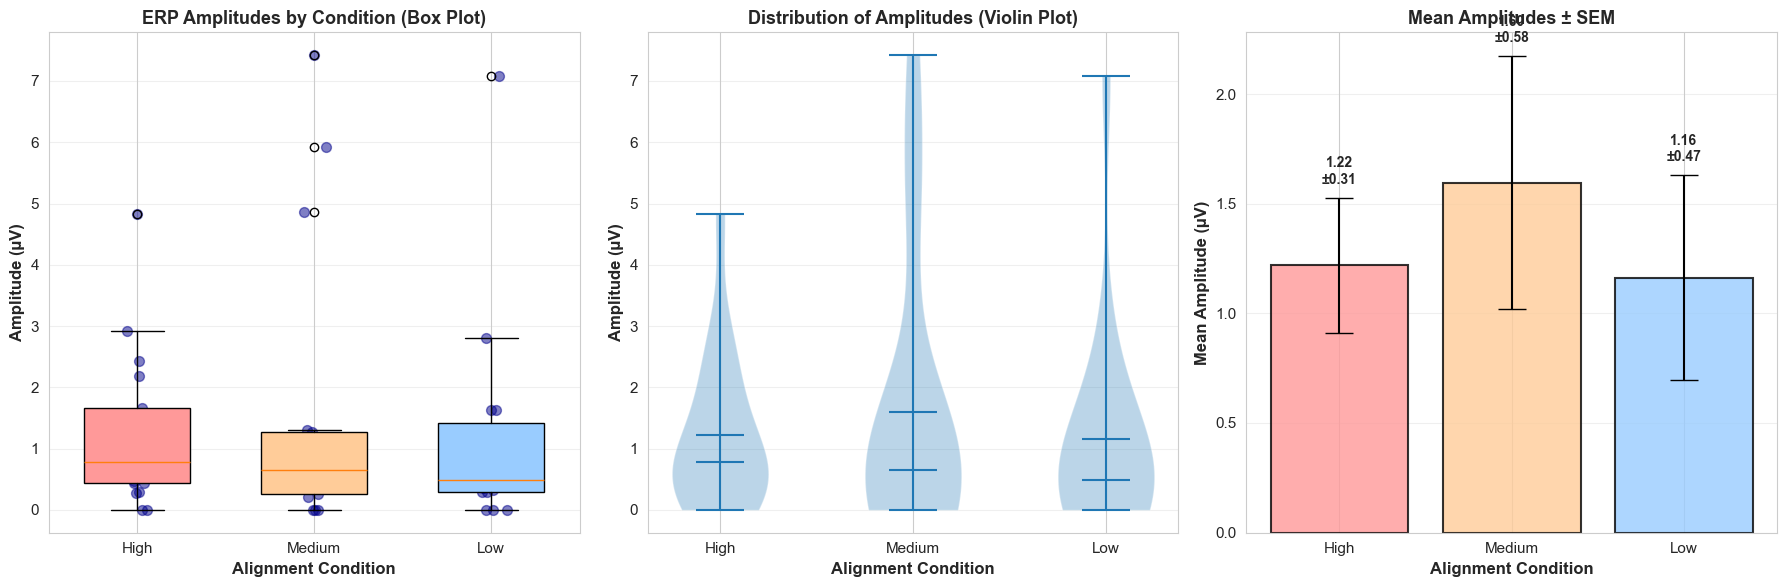


✓ Visualization saved to: ./results/comprehensive_analysis_plots.png


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Box plot with individual points
ax = axes[0]
data_for_plot = [high_vals, medium_vals, low_vals]
bp = ax.boxplot(data_for_plot, labels=conditions_list, patch_artist=True, widths=0.6)

colors = ['#ff9999', '#ffcc99', '#99ccff']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add individual points
for i, (vals, cond) in enumerate(zip(data_for_plot, conditions_list), 1):
    y = vals
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.5, s=50, color='darkblue')

ax.set_ylabel('Amplitude (µV)', fontsize=12, fontweight='bold')
ax.set_xlabel('Alignment Condition', fontsize=12, fontweight='bold')
ax.set_title('ERP Amplitudes by Condition (Box Plot)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Violin plot
ax = axes[1]
parts = ax.violinplot(data_for_plot, positions=[1, 2, 3], showmeans=True, showmedians=True)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(conditions_list)
ax.set_ylabel('Amplitude (µV)', fontsize=12, fontweight='bold')
ax.set_xlabel('Alignment Condition', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Amplitudes (Violin Plot)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Bar plot with error bars (Mean ± SEM)
ax = axes[2]
means = [np.mean(vals) for vals in data_for_plot]
sems = [np.std(vals, ddof=1)/np.sqrt(len(vals)) for vals in data_for_plot]

x_pos = np.arange(len(conditions_list))
bars = ax.bar(x_pos, means, yerr=sems, capsize=10, 
              color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_ylabel('Mean Amplitude (µV)', fontsize=12, fontweight='bold')
ax.set_xlabel('Alignment Condition', fontsize=12, fontweight='bold')
ax.set_title('Mean Amplitudes ± SEM', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(conditions_list)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, mean, sem) in enumerate(zip(bars, means, sems)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + sem + 0.05,
           f'{mean:.2f}\n±{sem:.2f}',
           ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('./results/comprehensive_analysis_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to: ./results/comprehensive_analysis_plots.png")

## 8. Summary Report

In [9]:
print("\n" + "="*100)
print("FINAL SUMMARY REPORT")
print("="*100)

print(f"\n📊 SAMPLE SIZES:")
for cond in conditions_list:
    n = len(df[df['condition'] == cond])
    print(f"  {cond}: n = {n}")

print(f"\n📈 DESCRIPTIVE STATISTICS:")
for cond in conditions_list:
    vals = df[df['condition'] == cond][dv].values
    print(f"  {cond}: M = {np.mean(vals):.2f} µV, SD = {np.std(vals, ddof=1):.2f} µV")

print(f"\n🔬 NORMALITY:")
if normal:
    print("  ✓ All conditions normally distributed (parametric tests used)")
else:
    print("  ✗ At least one condition non-normal (non-parametric tests used)")

print(f"\n📉 MAIN TEST:")
if normal:
    print(f"  One-Way ANOVA: F = {f_stat:.4f}, p = {p_val:.6f}")
else:
    print(f"  Kruskal-Wallis: H = {h_stat:.4f}, p = {p_val:.6f}")

if p_val < 0.05:
    print("  ✓ SIGNIFICANT difference across conditions")
else:
    print("  ✗ NO significant difference across conditions")

if p_val < 0.05 and len(posthoc_results) > 0:
    print(f"\n🔍 POST-HOC COMPARISONS (Bonferroni α = {alpha_bonferroni:.4f}):")
    for result in posthoc_results:
        sig_str = "✓ SIGNIFICANT" if result['Significant'] else "✗ Not significant"
        print(f"  {result['Comparison']}: p = {result['p-value']:.6f} → {sig_str}")

print(f"\n{'='*100}")
print("✓ Analysis complete!")
print(f"{'='*100}")


FINAL SUMMARY REPORT

📊 SAMPLE SIZES:
  High: n = 17
  Medium: n = 16
  Low: n = 15

📈 DESCRIPTIVE STATISTICS:
  High: M = 1.22 µV, SD = 1.27 µV
  Medium: M = 1.60 µV, SD = 2.31 µV
  Low: M = 1.16 µV, SD = 1.81 µV

🔬 NORMALITY:
  ✗ At least one condition non-normal (non-parametric tests used)

📉 MAIN TEST:
  Kruskal-Wallis: H = 0.5378, p = 0.764230
  ✗ NO significant difference across conditions

✓ Analysis complete!
